<a href="https://colab.research.google.com/github/softmaxbangkit/Capstone-Project/blob/main/model_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import io
import itertools
import shutil
import pathlib
import seaborn as sns
from zipfile import ZipFile
from PIL import Image
from datetime import datetime

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl

import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout, GlobalAveragePooling2D, Activation, MaxPooling2D, concatenate, BatchNormalization
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

##Data preprocessing 

In [ ]:
df = pd.read_csv('/Users/user/Desktop/b21_proj/Dataset/HAM10000_metadata.csv')

In [ ]:
imgs_dir = '/Users/user/Desktop/b21_proj/Dataset/all_image/'
class_name = ["akiec", 'bcc' ,'bkl' ,'df' ,'mel' ,'nv' ,'vasc']

img_dict = {}

for name in class_name:
  img_dict[name] = df[df['dx'] == name]['image_id'].to_list()

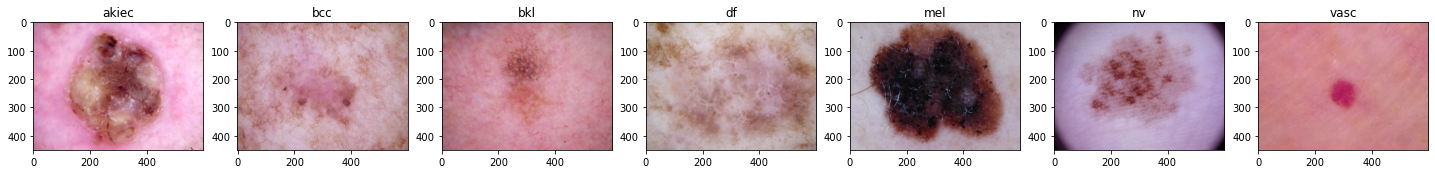

In [ ]:
import random

index = random.randint(0,100000)
count = 0

fig = plt.figure(figsize=[25,25])
axis = fig.subplots(1,7)

for name in class_name:
  total_img = len(img_dict[name])
  index_img_dir = os.path.join(imgs_dir, img_dict[name][index % total_img] + '.jpg')
  im = Image.open(index_img_dir)
  axis[count].imshow(im)
  axis[count].title.set_text(name)
  count += 1

plt.show(im)

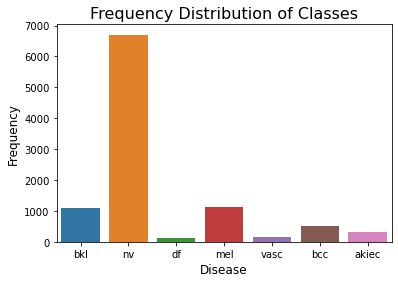

In [ ]:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)
plt.show()

In [ ]:
print('total data: {}'.format(df['dx'].count()))
print('dx count')
print(df['dx'].value_counts())

total data: 10015
dx count
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


Taking only the unique lesion_id

In [ ]:
df_count = df.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization,dataset
lesion_id,,,,,,,
HAM_0000000,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1


In [ ]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [ ]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'
  
df['is_duplicate'] = df['lesion_id'].apply(duplicates)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates


In [ ]:
df_count = df[df['is_duplicate'] == 'no']

Splitting data into train set and test set

In [ ]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [ ]:
def split_data(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
df['train_test_split'] = df['image_id'].apply(split_data)
train_df = df[df['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates,train


In [ ]:
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

Seperating each image to its train or test directory and its diagnosis

In [ ]:
stratify_split_dir = 'D:/proj_img/2018_image_dir/'
all_image_dir = 'C:/Users/user/Desktop/b21_proj/Dataset/all_image/'

for row in df.itertuples():
  image_id = row[2] + '.jpg'
  dx = row[3]
  splits = row[-1]

  imgs_path = os.path.join(all_image_dir, image_id)
  target_path = os.path.join(stratify_split_dir + splits + '/', dx)

  if not os.path.exists(target_path):
    pathlib.Path(target_path).mkdir(parents=True, exist_ok=True)

  shutil.copy(imgs_path, target_path)

Oversampling the train data with image augmentation

In [ ]:
class_name = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

train_dir = 'D:/proj_img/2018_image_dir/train/'
aug_dir_result = 'D:/proj_img/2018_aug_dir/train/'

image_size = 150

for img_class in class_name:
  temp_dir = 'D:/proj_img/temp_img/'
  os.mkdir(temp_dir)

  temp_child_dir = 'D:/proj_img/temp_img/child/'
  os.mkdir(temp_child_dir)

  source_dir = os.path.join(train_dir, img_class)
  target_dir = os.path.join(aug_dir_result, img_class)
  pathlib.Path(target_dir).mkdir(parents=True, exist_ok=True)

  datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
  )

  imgs_list = os.listdir(train_dir + img_class)

  for img in imgs_list:
    source = os.path.join(train_dir + img_class + '/', img)
    shutil.copy(source, temp_dir + 'child/')

  batch_size = 50

  aug_generator = datagen.flow_from_directory(
      temp_dir,
      batch_size=batch_size,
      save_to_dir=target_dir,
      save_format='jpg',
      target_size=(image_size, image_size)
  )

  aug_images = 6034

  num_files = len(os.listdir(source_dir))
  num_batches = int(np.ceil((aug_images - num_files) / batch_size))

  for i in range(0, num_batches):
    next(aug_generator)

  shutil.rmtree(temp_dir)

##Model Architecture

Load InceptionResNetV2 for transfer learning

In [ ]:
#InceptionResNetV2
irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    pooling=None,
    input_shape=(150,150,3),
    classifier_activation="softmax",
)
irv2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_325 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_324 (BatchN (None, 74, 74, 32)   96          conv2d_325[0][0]                 
__________________________________________________________________________________________________
activation_324 (Activation)     (None, 74, 74, 32)   0           batch_normalization_324[0][0]    
________________________________________________________________________________

Defining ImageDataGenerator for Model Fitting

In [ ]:
train_dir = 'D:/proj_img/dataset_2018/aug_dir/train/'
test_dir = 'D:/proj_img/dataset_2018/aug_dir/test/'
image_size = 150

datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=10,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 51699 images belonging to 7 classes.
Found 828 images belonging to 7 classes.


Adding layers on top of InceptionResNetV2 and layer for rescaling input images

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(150,150,3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
    irv2,
    Flatten(),
    Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 96775     
Total params: 54,433,511
Trainable params: 54,372,967
Non-trainable params: 60,544
_________________________________________________________________


Model Parameters and callbacks

In [ ]:
NUM_EPOCHS = 200
BATCH_SIZE = 64
version_name = 'InceptionResNetV2_2018_150x150'

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

save_model_dir = '/Users/user/Desktop/b21_proj/Model/' + version_name + '/'                                                 ## Change the last subdir for different model architectures
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_model_dir, monitor='val_accuracy', verbose=0, save_best_only=True)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, min_delta=0.001)

Training the model

In [ ]:
history = model.fit(train_generator,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    validation_data=test_generator,
                    callbacks=[checkpoint, earlyStop],
                    )

##Model Evaluation


Load the best model

In [ ]:
model = tf.keras.models.load_model('D:/final_project_files/' + version_name + '/')

In [ ]:
#'D:/final_project_files/test_dir/'
image_size = 150

datagen = ImageDataGenerator()

test_gen = datagen.flow_from_directory(
    '/content/gdrive/MyDrive/test_dir/',
    target_size=(image_size, image_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

Found 828 images belonging to 7 classes.


In [ ]:
val_loss, val_acc = model.evaluate(test_gen)

828/828 [==============================] - 119s 140ms/step - loss: 0.5094 - accuracy: 0.8756


In [ ]:
preds = model.predict(test_gen)
preds_list = []

for pred in preds:
  preds_list.append(np.argmax(pred))

report = classification_report(test_gen.classes, preds_list)

#class_name = ["akiec", 'bcc' ,'bkl' ,'df' ,'mel' ,'nv' ,'vasc']
print(report)

              precision    recall  f1-score   support

           0       0.53      0.43      0.48        23
           1       0.59      0.65      0.62        26
           2       0.60      0.55      0.57        66
           3       0.56      0.83      0.67         6
           4       0.46      0.62      0.52        34
           5       0.96      0.95      0.95       663
           6       1.00      0.80      0.89        10

    accuracy                           0.88       828
   macro avg       0.67      0.69      0.67       828
weighted avg       0.88      0.88      0.88       828



In [ ]:
dummy = []

for i in range(len(test_gen)):
  _, label = next(test_gen)
  dummy.append(label)

dummy = np.array(dummy)

true_labels = []

for j in range(len(dummy)):
  for i in range(len(dummy[j])):
    label = dummy[j][i]
    true_labels.append(label)

true_labels = np.array(true_labels)
prediction_labels = np.array(preds)

print(true_labels.shape)
print(prediction_labels.shape)

(828, 7)
(828, 7)


Top-n accuracy

In [ ]:
top_acc = []

for i in range(1,4):
  acc = TopKCategoricalAccuracy(k=i, name='top_k_categorical_accuracy')
  acc.update_state(true_labels, prediction_labels)

  key = 'top-' + str(i) + ' accuracy: {:.3f} %'.format(acc.result().numpy() * 100)
  top_acc.append(key)

for acc in top_acc:
  print(acc)

top-1 accuracy: 87.560 %
top-2 accuracy: 95.048 %
top-3 accuracy: 97.464 %


Predicting a single image

In [ ]:
test2018_path = 'D:/final_project_files/test_dir/'

diagnosis = 'mel'
img_name = 'ISIC_0029092.jpg'
img_path = os.path.join(test2018_path, diagnosis + '/' + img_name)

img = image.load_img((img_path), target_size=(150,150))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

pred_saved_model = model.predict(img_batch)

def top_n_pred(prediction, k):
  class_names = ["akiec", 'bcc' ,'bkl' ,'df' ,'mel' ,'nv' ,'vasc']
  top_k_result = k
  _, top_k_indices = tf.math.top_k(prediction, k=top_k_result)

  result_top_3 = {}

  top_k_indices = top_k_indices.numpy()

  for i in range(3):
    index = top_k_indices[0][i]
    result_top_3[class_names[index]] = prediction[0][index] * 100

  result_top_3 = sorted(result_top_3.items(), key=lambda x: x[1], reverse=True)
  return(result_top_3)

top_n = top_n_pred(pred_saved_model,3)
print(top_n)

[('mel', 99.98857975006104), ('nv', 0.010123920947080478), ('vasc', 0.0013010674592806026)]


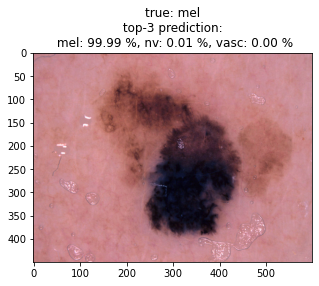

In [ ]:
fig = plt.figure(figsize=[5,5])

im = Image.open(img_path)
plt.imshow(im)
plt.title('true: {}\n top-3 prediction: \n {}: {:.2f} %, {}: {:.2f} %, {}: {:.2f} %'.format(diagnosis, top_n[0][0], top_n[0][1], top_n[1][0], top_n[1][1], top_n[2][0], top_n[2][1]))
plt.show()

##Convert Model to TFLite Format

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Saving model to tflite with Dynamic quantization

In [ ]:
model_path = 'D:/final_project_files/InceptionResNetV2_2018_150x150/'
tf.saved_model.save(model, model_path)

In [ ]:
tflite_path = 'D:/final_project_files/InceptionResNetV2_150x150_dynamic.tflite'

converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
tf_lite_model_file = pathlib.Path(tflite_path)
tf_lite_model_file.write_bytes(tflite_model)

56233680

Evaluation with tflite model

In [ ]:
#tflite_path = 'D:/final_project_files/InceptionResNetV2_150x150_dynamic.tflite'
tflite_path = '/content/gdrive/MyDrive/tflite/InceptionResNetV2_150x150_dynamic.tflite'

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

In [ ]:
interpreter.set_tensor(input_details[0]['index'], img_batch)
interpreter.invoke()
pred_tflite = interpreter.get_tensor(output_details[0]['index'])

Result comparison

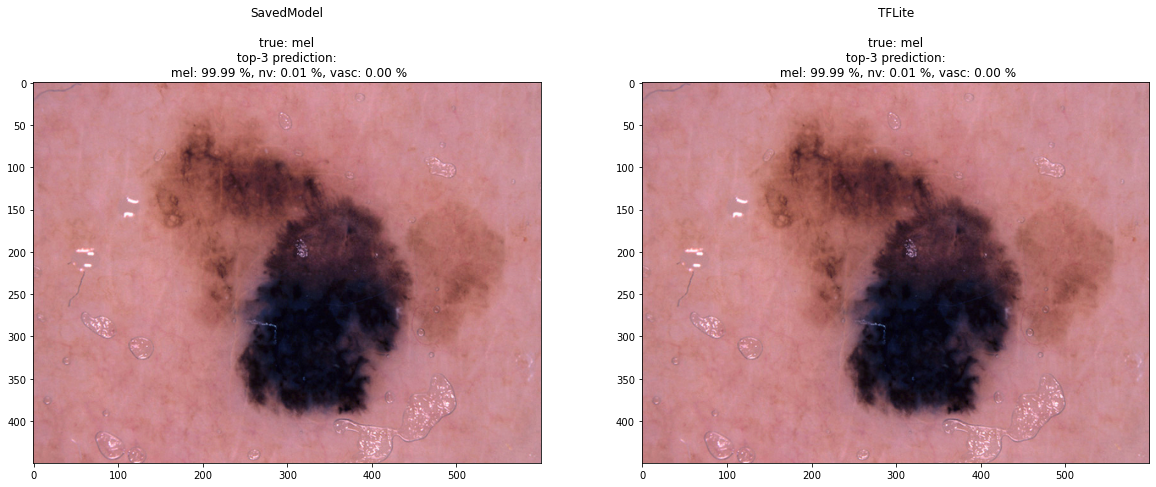

In [ ]:
top_n_tflite = top_n_pred(pred_tflite, 3)

fig = plt.figure(figsize=[20,20])
axis = fig.subplots(1,2)

im = Image.open(img_path)

axis[0].imshow(im)
axis[0].title.set_text('SavedModel\n\ntrue: {}\n top-3 prediction: \n {}: {:.2f} %, {}: {:.2f} %, {}: {:.2f} %'.format(diagnosis, top_n[0][0], top_n[0][1], top_n[1][0], top_n[1][1], top_n[2][0], top_n[2][1]))

axis[1].imshow(im)
axis[1].title.set_text('TFLite\n\ntrue: {}\n top-3 prediction: \n {}: {:.2f} %, {}: {:.2f} %, {}: {:.2f} %'.format(diagnosis, top_n_tflite[0][0], top_n_tflite[0][1], top_n_tflite[1][0], top_n_tflite[1][1], top_n_tflite[2][0], top_n_tflite[2][1]))
plt.show()

TFLite accuracy

In [ ]:
pred_tflite_res = []
true_label_tflite = []

for i in range(len(test_gen)):
  imgs, labels = next(test_gen)
  for img in imgs:
    img = np.expand_dims(img, axis=0)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    pred_tflite_res.append(interpreter.get_tensor(output_details[0]['index']))
  for label in labels:
    true_label_tflite.append(label)

final_pred_tflite = []
final_label_tflite = []

for pred in pred_tflite_res:
  final_pred_tflite.append(np.argmax(pred))

for label in true_label_tflite:
  final_label_tflite.append(np.argmax(label))

score = 0
for i in range(len(final_pred_tflite)):
  if final_pred_tflite[i] == final_label_tflite[i]:
    score += 1

In [ ]:
print('TFLite model accuracy : {:.4f} %'.format((score / len(test_gen)) * 100))
print('SavedModel accuracy : {:.4f} %'.format(val_acc * 100))

TFLite model accuracy : 87.5604 %
SavedModel accuracy : 87.5604 %


In [ ]:
report = classification_report(final_label_tflite, final_pred_tflite)
print('\t\t\tTFLite Model Report\n')
print(report)

			TFLite Model Report

              precision    recall  f1-score   support

           0       0.53      0.43      0.48        23
           1       0.59      0.65      0.62        26
           2       0.61      0.52      0.56        66
           3       0.56      0.83      0.67         6
           4       0.45      0.65      0.53        34
           5       0.96      0.95      0.95       663
           6       1.00      0.80      0.89        10

    accuracy                           0.88       828
   macro avg       0.67      0.69      0.67       828
weighted avg       0.88      0.88      0.88       828

